In [1]:
import tensorflow as tf
import numpy as np
import functools
import vgg19
from vgg19 import *
from utils import *

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import scipy.misc, numpy as np, os, sys

# Load data

In [3]:
def _get_files(img_dir):
    files = list_files(img_dir)
    return [os.path.join(img_dir,x) for x in files]

In [4]:
content_targets = _get_files('../../../train-data/train2014/')

In [5]:
len(content_targets)

82783

### Access S3 style image

In [6]:
import boto3
import botocore
from io import BytesIO
from PIL import Image

In [7]:
BUCKET_NAME = 'fast-style-transfer'

In [8]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(BUCKET_NAME)

In [9]:
def get_train_image(image_path, img_size=False):
    with BytesIO() as files:
        #path = "train2014-images/COCO_train2014_000000000049.jpg"
        s3.Bucket(BUCKET_NAME).download_fileobj(image_path, files)
        image = np.asarray(Image.open(files))
        if not (len(image.shape) == 3 and image.shape[2] == 3):
            image = np.dstack((image,image,image))
        
        if img_size != False:
            image = scipy.misc.imresize(image, img_size)
            
        return(image)

In [10]:
style_target = get_train_image("images/la_muse.jpg")

In [11]:
from matplotlib.pyplot import imshow
%matplotlib inline

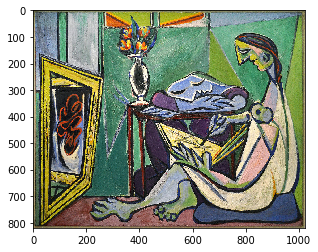

In [23]:
imshow(style_target)

# Graph functions

In [13]:
WEIGHTS_INIT_STDEV = .1

### Convolutional layer with instance normalisation

In [14]:
def _conv_layer(net, num_filters, filter_size, strides, relu=True):
    weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME')
    net = _instance_norm(net)
    if relu:
        net = tf.nn.relu(net)

    return net

In [15]:
def _instance_norm(net, train=True):
    batch, rows, cols, channels = [i.value for i in net.get_shape()]
    var_shape = [channels]
    mu, sigma_sq = tf.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))
    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)
    return scale * normalized + shift

### Transpose convolutional layer with instance normalisation

In [16]:
def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    batch_size, rows, cols, in_channels = [i.value for i in net.get_shape()]
    new_rows, new_cols = int(rows * strides), int(cols * strides)
    # new_shape = #tf.pack([tf.shape(net)[0], new_rows, new_cols, num_filters])

    new_shape = [batch_size, new_rows, new_cols, num_filters]
    tf_shape = tf.stack(new_shape)
    strides_shape = [1,strides,strides,1]

    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')
    net = _instance_norm(net)
    return tf.nn.relu(net)

### Weight initialization

In [17]:
def _conv_init_vars(net, out_channels, filter_size, transpose=False):
    _, rows, cols, in_channels = [i.value for i in net.get_shape()]
    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.truncated_normal(weights_shape, stddev=WEIGHTS_INIT_STDEV, seed=1), dtype=tf.float32)
    return weights_init

### Residual block

In [18]:
def _residual_block(net, filter_size=3):
    tmp = _conv_layer(net, 128, filter_size, 1)
    return net + _conv_layer(tmp, 128, filter_size, 1, relu=False)

### Graph construction

In [19]:
def image_maker(image):
    conv1 = _conv_layer(image, 32, 9, 1)
    conv2 = _conv_layer(conv1, 64, 3, 2)
    conv3 = _conv_layer(conv2, 128, 3, 2)
    resid1 = _residual_block(conv3, 3)
    resid2 = _residual_block(resid1, 3)
    resid3 = _residual_block(resid2, 3)
    resid4 = _residual_block(resid3, 3)
    resid5 = _residual_block(resid4, 3)
    conv_t1 = _conv_tranpose_layer(resid5, 64, 3, 2)
    conv_t2 = _conv_tranpose_layer(conv_t1, 32, 3, 2)
    conv_t3 = _conv_layer(conv_t2, 3, 9, 1, relu=False)
    preds = tf.nn.tanh(conv_t3) * 150 + 255./2
    return preds

## Optimize

### Settings

In [24]:
vgg19_path = '../../../vgg19-model/imagenet-vgg-verydeep-19.mat'
epochs = 2
batch_size = 4
content_weight = 7.5*2
style_weight = 1e2
tv_weight = 2e2
learning_rate = 1e-3
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')
CONTENT_LAYER = 'relu4_2'

### Compute style features

In [25]:
#If run on AWS
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth=True

In [26]:
style_features = {}

with tf.Graph().as_default(), tf.device('/gpu:0'), tf.Session(config=config) as sess:
    style_target_reshape = np.array([style_target])
    style_image = tf.placeholder(tf.float32, shape = style_target_reshape.shape, name = 'style_image')
    style_image_proc = vgg19.preprocess(style_image)
    network = vgg19.net(vgg19_path, style_image_proc)
    for layer in STYLE_LAYERS:
        features = sess.run(network[layer], feed_dict={style_image: style_target_reshape})
        features = np.reshape(features, (-1, features.shape[3]))
        gram_matrix = np.matmul(features.T, features) / features.size
        style_features[layer] = gram_matrix

### Compute content loss

In [ ]:
batch_shape = (batch_size, 256, 256 ,3)

with tf.Graph().as_default(), tf.Session(config=config) as sess:
    X_content = tf.placeholder(tf.float32, shape=batch_shape, name='X_content')
    X_proc = vgg19.preprocess(X_content)
    
    content_features = {}
    content_net = vgg19.net(vgg19_path, X_proc)
    content_features[CONTENT_LAYER] = content_net[CONTENT_LAYER]
    
    generated_image = image_maker(X_content/255.0)
    generated_image_proc = vgg19.preprocess(generated_image)
    
    generated_image_net = vgg19.net(vgg19_path, generated_image_proc)
    content_size = tf.size(content_features[CONTENT_LAYER], out_type=tf.float32)
    content_loss = content_weight * (tf.nn.l2_loss(generated_image_net[CONTENT_LAYER] - content_features[CONTENT_LAYER])) / content_size
    
    #Style loss
    style_losses = []
    for style_layer in STYLE_LAYERS:
        layer = generated_image_net[style_layer]
        layer_shape = layer.get_shape().as_list()
        size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        feats = tf.reshape(layer, (layer_shape[0], layer_shape[1] * layer_shape[2], layer_shape[3]))
        feats_T = tf.transpose(feats, perm=[0,2,1])
        grams = tf.matmul(feats_T, feats) / size
        style_gram = style_features[style_layer]
        style_losses.append(2 * tf.nn.l2_loss(grams - style_gram))
        
    style_loss = style_weight * functools.reduce(tf.add, style_losses) / batch_size
    
    #total variation denoising
    tv_size = tf.size(generated_image, out_type=tf.float32) - 1
    y_tv = tf.nn.l2_loss(generated_image[:,1:,:,:] - generated_image[:,:-1,:,:])
    x_tv = tf.nn.l2_loss(generated_image[:,:,1:,:] - generated_image[:,:,:-1,:])
    tv_loss = tv_weight*2*(x_tv/tv_size + y_tv/tv_size)
    
    loss = content_loss + style_loss + tv_loss
    
    #optimize
    optimize = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        num_examples = len(content_targets)
        batch_iterations = int(num_examples/batch_size)
        for i in range(batch_iterations):
            print('i:',i)
            curr = i * batch_size
            step = curr + batch_size
            X_batch = np.zeros(batch_shape, dtype=np.float32)
            for j, img_p in enumerate(content_targets[curr:step]):
                X_batch[j] = get_img(img_p, (256,256,3)).astype(np.float32)        
            #optimize.run(feed_dict={X_content: X_batch})
            _, loss_value = sess.run([optimize, loss], feed_dict={X_content: X_batch})
            print('loss:', loss_value)
        print('epoch:', epoch)
        
    saver = tf.train.Saver()
    res = saver.save(sess, '../../saved_model/model1.ckpt')

i: 0
loss: 59186430000000.0
i: 1
loss: 32256633000000.0
i: 2
loss: 21878809000000.0
i: 3
loss: 17654258000000.0
i: 4
loss: 17988586000000.0
i: 5
loss: 17562313000000.0
i: 6
loss: 17333776000000.0
i: 7
loss: 17535980000000.0
i: 8
loss: 16521259000000.0
i: 9
loss: 16142718000000.0
i: 10
loss: 16525334000000.0
i: 11
loss: 15607903000000.0
i: 12
loss: 15176342000000.0
i: 13
loss: 14651292000000.0
i: 14
loss: 14667077000000.0
i: 15
loss: 13572454000000.0
i: 16
loss: 14260508000000.0
i: 17
loss: 13218133000000.0
i: 18
loss: 11837182000000.0
i: 19
loss: 12899699000000.0
i: 20
loss: 11961335000000.0
i: 21
loss: 11819330000000.0
i: 22
loss: 11634468000000.0
i: 23
loss: 11921745000000.0
i: 24
loss: 11074225000000.0
i: 25
loss: 10629366000000.0
i: 26
loss: 10848792000000.0
i: 27
loss: 10295492000000.0
i: 28
loss: 9910398000000.0
i: 29
loss: 9467032000000.0
i: 30
loss: 9252939000000.0
i: 31
loss: 9046503000000.0
i: 32
loss: 8633596000000.0
i: 33
loss: 9070820000000.0
i: 34
loss: 8655416600000.0
i:

loss: 2387241300000.0
i: 287
loss: 1941369700000.0
i: 288
loss: 2223334200000.0
i: 289
loss: 2187819000000.0
i: 290
loss: 2085200100000.0
i: 291
loss: 2510847200000.0
i: 292
loss: 1961059300000.0
i: 293
loss: 2009054200000.0
i: 294
loss: 2043008300000.0
i: 295
loss: 2026052900000.0
i: 296
loss: 2081511700000.0
i: 297
loss: 2054521600000.0
i: 298
loss: 2150955000000.0
i: 299
loss: 1871708800000.0
i: 300
loss: 2324817000000.0
i: 301
loss: 2122803300000.0
i: 302
loss: 1901433200000.0
i: 303
loss: 1991861000000.0
i: 304
loss: 2173451000000.0
i: 305
loss: 1975687400000.0
i: 306
loss: 2319780400000.0
i: 307
loss: 1975905700000.0
i: 308
loss: 1879764600000.0
i: 309
loss: 2105462900000.0
i: 310
loss: 2011103900000.0
i: 311
loss: 2093326400000.0
i: 312
loss: 1913024400000.0
i: 313
loss: 1809376100000.0
i: 314
loss: 2043983200000.0
i: 315
loss: 1815200700000.0
i: 316
loss: 1841457100000.0
i: 317
loss: 2084609000000.0
i: 318
loss: 2156758000000.0
i: 319
loss: 1772433300000.0
i: 320
loss: 19196228

loss: 1391002300000.0
i: 570
loss: 1172103600000.0
i: 571
loss: 1265622800000.0
i: 572
loss: 1159410400000.0
i: 573
loss: 1386814900000.0
i: 574
loss: 1288767000000.0
i: 575
loss: 1249611900000.0
i: 576
loss: 1121882700000.0
i: 577
loss: 1249823000000.0
i: 578
loss: 1213179500000.0
i: 579
loss: 1252646300000.0
i: 580
loss: 1207791600000.0
i: 581
loss: 1255889800000.0
i: 582
loss: 1234179200000.0
i: 583
loss: 1243000500000.0
i: 584
loss: 1207555300000.0
i: 585
loss: 1277415700000.0
i: 586
loss: 1158342600000.0
i: 587
loss: 1339999500000.0
i: 588
loss: 1229640300000.0
i: 589
loss: 1311797700000.0
i: 590
loss: 1119477700000.0
i: 591
loss: 1312593300000.0
i: 592
loss: 1155948000000.0
i: 593
loss: 1257480700000.0
i: 594
loss: 1231083700000.0
i: 595
loss: 1211644800000.0
i: 596
loss: 1168084600000.0
i: 597
loss: 1184999800000.0
i: 598
loss: 1207364500000.0
i: 599
loss: 1077618600000.0
i: 600
loss: 1195679200000.0
i: 601
loss: 1101230200000.0
i: 602
loss: 1537773700000.0
i: 603
loss: 12759997

loss: 1065578660000.0
i: 855
loss: 973156200000.0
i: 856
loss: 961779470000.0
i: 857
loss: 926155500000.0
i: 858
loss: 972263400000.0
i: 859
loss: 1007785900000.0
i: 860
loss: 972273350000.0
i: 861
loss: 941043550000.0
i: 862
loss: 881817750000.0
i: 863
loss: 904849200000.0
i: 864
loss: 910778200000.0
i: 865
loss: 1014154700000.0
i: 866
loss: 922948530000.0
i: 867
loss: 914055800000.0
i: 868
loss: 911542800000.0
i: 869
loss: 873610400000.0
i: 870
loss: 848190240000.0
i: 871
loss: 1026229200000.0
i: 872
loss: 874236740000.0
i: 873
loss: 836772500000.0
i: 874
loss: 860287200000.0
i: 875
loss: 854437400000.0
i: 876
loss: 942399360000.0
i: 877
loss: 922029850000.0
i: 878
loss: 894038500000.0
i: 879
loss: 892001600000.0
i: 880
loss: 941916160000.0
i: 881
loss: 817780800000.0
i: 882
loss: 1005703860000.0
i: 883
loss: 909154250000.0
i: 884
loss: 893348100000.0
i: 885
loss: 916547200000.0
i: 886
loss: 842070900000.0
i: 887
loss: 934061700000.0
i: 888
loss: 895285900000.0
i: 889
loss: 952028100

loss: 734543300000.0
i: 1143
loss: 798050350000.0
i: 1144
loss: 820614600000.0
i: 1145
loss: 797387900000.0
i: 1146
loss: 794827160000.0
i: 1147
loss: 921572100000.0
i: 1148
loss: 816995100000.0
i: 1149
loss: 750531640000.0
i: 1150
loss: 781018460000.0
i: 1151
loss: 841133400000.0
i: 1152
loss: 759454000000.0
i: 1153
loss: 857410800000.0
i: 1154
loss: 832619940000.0
i: 1155
loss: 841681800000.0
i: 1156
loss: 801379500000.0
i: 1157
loss: 860672560000.0
i: 1158
loss: 764173300000.0
i: 1159
loss: 725124600000.0
i: 1160
loss: 769277000000.0
i: 1161
loss: 850841630000.0
i: 1162
loss: 816971900000.0
i: 1163
loss: 793847100000.0
i: 1164
loss: 831751800000.0
i: 1165
loss: 819584430000.0
i: 1166
loss: 718835200000.0
i: 1167
loss: 856759340000.0
i: 1168
loss: 720118200000.0
i: 1169
loss: 681290960000.0
i: 1170
loss: 737720700000.0
i: 1171
loss: 750402100000.0
i: 1172
loss: 788332150000.0
i: 1173
loss: 865302400000.0
i: 1174
loss: 714998800000.0
i: 1175
loss: 750154300000.0
i: 1176
loss: 79257460

loss: 756561200000.0
i: 1426
loss: 685640800000.0
i: 1427
loss: 800364900000.0
i: 1428
loss: 667860140000.0
i: 1429
loss: 701723440000.0
i: 1430
loss: 731497230000.0
i: 1431
loss: 701564900000.0
i: 1432
loss: 667231700000.0
i: 1433
loss: 701087550000.0
i: 1434
loss: 669508000000.0
i: 1435
loss: 647707800000.0
i: 1436
loss: 736822000000.0
i: 1437
loss: 620444900000.0
i: 1438
loss: 743558350000.0
i: 1439
loss: 651737900000.0
i: 1440
loss: 756150000000.0
i: 1441
loss: 769766650000.0
i: 1442
loss: 652310900000.0
i: 1443
loss: 689113000000.0
i: 1444
loss: 740793840000.0
i: 1445
loss: 671134200000.0
i: 1446
loss: 650815730000.0
i: 1447
loss: 677449100000.0
i: 1448
loss: 639699260000.0
i: 1449
loss: 669420550000.0
i: 1450
loss: 766494700000.0
i: 1451
loss: 757185700000.0
i: 1452
loss: 693595000000.0
i: 1453
loss: 713937060000.0
i: 1454
loss: 737138440000.0
i: 1455
loss: 780821600000.0
i: 1456
loss: 707464700000.0
i: 1457
loss: 638827360000.0
i: 1458
loss: 718833100000.0
i: 1459
loss: 68519834